In [1]:
import delfi.distribution as dd
import delfi.generator as dg
import delfi.inference as infer
import delfi.summarystats as ds

%run ../DDELFI.py

import scipy as sp

from delfi.simulator.BaseSimulator import BaseSimulator

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
from delfi.utils.viz import plot_pdf

from delfi.simulator import Gauss

from tqdm import tqdm_notebook as tqdm

from parameters import ParameterSet

%matplotlib inline

In [2]:
class DividedPdf:
    def __init__(self, a, b, norm_region):
        self.a = a
        self.b = b
        
        
        self.ndim = self.a.ndim
        
        self.Z = 1
        
        xlist = np.linspace(norm_region[0], norm_region[1], 1000)
        samples = self.eval(xlist.reshape(-1,1), log=False)
        
        dx = xlist[1] - xlist[0]
        
        mass = np.sum(samples) * dx
        self.Z = mass
        
    def eval(self, samples, log=True):
        ret = self.a.eval(samples, log=False) / self.b.eval(samples, log=False)
        ret /= self.Z
        if log:
            return np.log(ret)
        else:
            return ret
    
class MultipliedPdf:
    def __init__(self, a, b, norm_region):
        self.a = a
        self.b = b
        
        self.ndim = self.a.ndim
        
        self.Z = 1
        
        xlist = np.linspace(norm_region[0], norm_region[1], 1000)
        samples = self.eval(xlist.reshape(-1,1), log=False)
        
        dx = xlist[1] - xlist[0]
        
        mass = np.sum(samples) * dx
        self.Z = mass
        
    def eval(self, samples, ii=None, log=True):
        ret = self.a.eval(samples, ii=ii, log=False) * self.b.eval(samples, ii=ii, log=False)
        ret /= self.Z
        if log:
            return np.log(ret)
        else:
            return ret
    
def divide_dists(a, b, norm_region):
    if isinstance(a, dd.Gaussian) and isinstance(b, dd.Gaussian):
        return a / b
    
    return DividedPdf(a, b, norm_region)

def multiply_dists(a, b, norm_region):
    if isinstance(a, dd.Gaussian) and isinstance(b, dd.Gaussian):
        return a * b
    
    return MultipliedPdf(a, b, norm_region)

In [3]:
class BimodalGaussian(BaseSimulator):
    def __init__(self, slope, noise_var, seed = None):
        super().__init__(dim_param=1, seed=seed)
        self.slope = slope
        self.noise_var = noise_var
        
    def gen_single(self, params):
        dist = self.get_likelihood(params)
        sample = dist.gen(1).reshape(-1)
        return { 'data' : sample }
    
    def get_likelihood(self, params):
        return dd.MoG(a=[0.5, 0.5], ms=[self.slope * params, -self.slope * params], Ss = 2 * [np.eye(1) * self.noise_var])

In [32]:
def run_panel(algo, params, seed=None):
    if seed is None:
        seed = params.seed
        
    m = BimodalGaussian(params.slope, params.noise_cov, seed=seed)
    s = ds.Identity(1)
    g = dg.Default(model=m, prior=params.prior, summary=s)
    
    kws = { 'generator' : g,
            'obs' : [params.obs_stats],
            'n_hiddens' : params.n_hiddens,
            'seed' : seed,
            'verbose' : True,
            'svi' : False }
    
    run_kws = {}
    if algo == 'DDELFI':
        res = DDELFI(**kws, prior_mixin=0.1)
    elif algo == 'SNPE':
        res = infer.SNPE(**kws, convert_to_T=3)
        run_kwargs = { 'round_cl' : 1000 }
    elif algo == 'kSNPE':
        res = infer.SNPE(**kws, convert_to_T=3)
        run_kwargs = { 'round_cl' : 1000, 'kernel_loss' : 'x_kl' }
    elif algo == 'CDELFI':
        res = infer.CDELFI(**kws)
    else:
        raise NotImplemented("Unknown algorithm")
    
    ret = res.run(n_train=params.n_train, n_rounds = params.n_rounds, **run_kws)

    posteriors = ret[2]
    return posteriors

In [56]:
params = ParameterSet({})

params.seed = 394
params.n_hiddens = [ 20 ] * 2

params.noise_cov = 0.1

params.n_train = 500
params.n_rounds = 3

params.prior_width = 5

params.n_runs = 1

params.slope = 3

params.true_params = np.array([ 3 ])

In [57]:
params.prior = dd.Uniform(lower=-params.prior_width, upper=params.prior_width)

params.obs_stats = params.true_params * params.slope

params.gt = dd.MoG(a=[0.5,0.5], ms=[params.obs_stats / params.slope, -params.obs_stats / params.slope], 
                   Ss = 2 * [np.eye(1) * params.noise_cov])

In [58]:
COL = { 'DDELFI' : 'orange', 'SNPE' : 'r', 'kSNPE' : 'g', 'CDELFI' : 'k' }

In [59]:
def plot_row(data):
    plt.figure(figsize=(16,5))
    
    algos = data.keys()
    
    xlist = np.linspace(-params.prior_width, params.prior_width, 200)
    
    for i, algo in enumerate(algos):
        plt.subplot(1, len(algos), i + 1)
        
        for posterior in data[algo]:
            if posterior is not None:
                ylist = posterior.eval(xlist.reshape(-1,1), log=False)
                ls = '--'

                if posterior == data[algo][-1]:
                    ls = None

                plt.plot(xlist, ylist, color=COL[algo], linewidth=2, ls=ls)
                
        ax = plt.gca()
        ax.set_title(algo)
        ax.set_yticks([])
        ax.axvline(params.true_params, color='gray', ls='--')
        plt.xticks([params.true_params], ['$x_o$'])
            
        plt.legend()
        
    plt.show()
        

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.43442941]: : 11it [00:00, 68.79it/s] 

loss=[ 2.42017078]: : 1730it [00:14, 116.51it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.38978291]: : 9it [00:00, 70.47it/s]

loss=[ 2.38971949]: : 1056it [00:10, 102.80it/s]


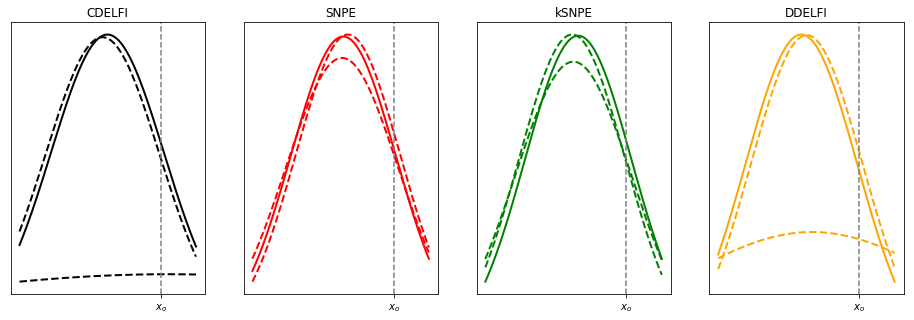

In [60]:
std_params = params

algos = [ 'CDELFI', 'SNPE', 'kSNPE', 'DDELFI' ]
out = { algo : [] for algo in algos }

for r in range(params.n_runs):
    for algo in algos:
        out[algo].append(run_panel(algo, params, seed=params.seed + r))
        
    plot_row({ algo : out[algo][-1] for algo in algos })

In [ ]:
for r in range(params.n_runs):
    plot_row({ algo : out[algo][-1] for algo in algos })

In [ ]:
for r, posterior in enumerate(posteriors[0:]):
    plot_pdf(posterior, 
             lims=[-params.prior_width,params.prior_width],  
             pdf2=params.gt,
             gt=params.true_params, 
             figsize=(9,9));

In [ ]:
for pred in preds[1:]:
    lhs = multiply_dists(pred['proposal'], pred['posterior'], (-params.prior_width * 5, params.prior_width * 5))
    rhs = multiply_dists(pred['prior'], pred['qphi'], (-params.prior_width * 5, params.prior_width * 5))
    
    plot_pdf(lhs, 
             pdf2 = rhs,
             lims=[-params.prior_width,params.prior_width],  
             figsize=(9,9));

In [ ]:
pred = preds[-1]

trainer = MoGTrainer(prop=pred['proposal'], 
                     prior=pred['prior'], 
                     qphi=pred['qphi'], 
                     n_components=params.n_comps, 
                     nsamples=10000)
            
trainer.train(nsteps=-1)
            
posterior = trainer.get_mog()

In [ ]:
plot_pdf(posterior, 
         pdf2 = params.gt,
         lims=[-params.prior_width,params.prior_width],  
         gt=params.true_params, 
         figsize=(9,9));